In [51]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import tree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from IPython.display import Image
from sklearn.metrics import log_loss
import seaborn as sns
from pretty_confusion_matrix import pp_matrix

### Function to print energy plots for mislabeled events:

In [52]:
def MislabeledEventPlotter(df):
    layers= [i for i in list(df.columns) if "Layer" in i]
    layer_energies = df[layers]  
    for i in range(len(df)):
        plt.bar(x = np.array(range(1, 41)), height = np.array(layer_energies.loc[i]))
        plt.xlabel("Layers")
        plt.ylabel("Energy")
        plt.title("Energy per Layer (MIP) \n Particle: {particle} \n Prediction: {prediction} \n Index: {index}".format(
            particle = df.loc[i]["Particle"], index =df.loc[i]["Index"], prediction = df.loc[i]["Prediction"]))
        plt.show()
        print("-"*110)

### Building the classifier:


In [53]:
def ModelDecisionTree(df, depth):

    def split_dataset_stratified(df):
        # Separating the target variable
        X = df.drop("Particle", inplace=False, axis=1)
        Y = df["Particle"]
        X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                            test_size = 0.3,
                                                            random_state = 100,
                                                            shuffle = True, stratify = Y)
        return X, Y, X_train, X_test, y_train, y_test


    def train(X_train, X_test, y_train):
        # Creating the classifier object
        clf = DecisionTreeClassifier(criterion="gini", max_depth=depth,
                                          random_state=100)

        # Performing training
        clf.fit(X_train, y_train)
        return clf

    def prediction(X_test, clf_object):
        # Predicton on test with giniIndex
        y_pred = clf_object.predict(X_test)
        indices = list(X_test.index)
        data = {"Index": indices, "Prediction": y_pred}
        y_pred_df = pd.DataFrame(data=data)
        return y_pred, y_pred_df

    def cal_accuracy(y_test, y_pred):
        print("Report : ",
              classification_report(y_test, y_pred))
        print("The Confusion Matrix: ")
        cm = confusion_matrix(y_test, y_pred, labels=list(df["Particle"].unique()))            
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=df["Particle"].unique())
        disp.plot(cmap = "Reds")
        
    def GetMislabeledEventDf(y_test, y_pred):
        y_test.reset_index(inplace=True)
        y_test.rename(columns = {"index": "Index"}, inplace = True)
        y_merged = pd.merge(y_test, y_pred, on="Index")
        mislabeled_events = []
        for i in range(len(y_merged)):
            if y_merged.loc[i]["Particle"] != y_merged.loc[i]["Prediction"]:
                mislabeled_events.append(y_merged.loc[i]["Index"])
                
        mislabeled_events_df = df.loc[mislabeled_events]
        mislabeled_events_df.reset_index(inplace=True),
        mislabeled_events_df.rename(columns={"index": "Index"}, inplace=True)
        mislabeled_events_df= mislabeled_events_df.merge(y_pred, on = "Index")
        return mislabeled_events_df

        
    # Building Phase
    data = df
    X, y, X_train, X_test, y_train, y_test = split_dataset_stratified(data)
    clf = train(X_train, X_test, y_train)
    

    # Prediction
    y_pred, y_pred_df = prediction(X_test, clf)
    y_test_df = pd.DataFrame(y_test)
    cal_accuracy(y_test, y_pred)
    
    features = [f for f in X_train.columns]
    feature_importance_df = pd.DataFrame()
    feature_importance_df["feature"] = features
    feature_importance_df["importance"] = clf.feature_importances_
    
    fig = plt.figure(figsize=(45,40))
    _ = tree.plot_tree(clf, feature_names=features, 
                       class_names=["muon","ele_high", "pion_low","ele_low", "pion_high"], 
                       filled=True)
    
    mislabeled_events_df = GetMislabeledEventDf(y_test_df, y_pred_df)
    return mislabeled_events_df, feature_importance_df

In [54]:
def DisplayImportances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Decision Tree Features')
    plt.tight_layout()

In [126]:
def GetDatasetDescription(df):
    print("Target particles: \n", list(df["Particle"].unique()))
    print("- "*40)
    print("Number of events: ", len(df))
    print()
    print(df["Particle"].value_counts())
    print("- "*40)
    if len(df.columns) > 41:
        print("Features: Layer energies and", list(df.columns[41:44]))
    else: 
        print("Features: Layer energies")

## Experiment 1

Take a look at the data:

In [56]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [55]:
df = pd.read_csv("df_high_and_low.csv")

In [128]:
GetDatasetDescription(df)

Target particles: 
 ['ele_high', 'pion_high', 'muon', 'ele_low', 'pion_low']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Number of events:  525

ele_high     109
ele_low      105
muon         104
pion_low     104
pion_high    103
Name: Particle, dtype: int64
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Features: Layer energies


### Training:

Report :                precision    recall  f1-score   support

    ele_high       0.97      1.00      0.99        33
     ele_low       1.00      0.94      0.97        32
        muon       0.79      0.84      0.81        31
   pion_high       1.00      0.90      0.95        31
    pion_low       0.73      0.77      0.75        31

    accuracy                           0.89       158
   macro avg       0.90      0.89      0.89       158
weighted avg       0.90      0.89      0.89       158

The Confusion Matrix: 


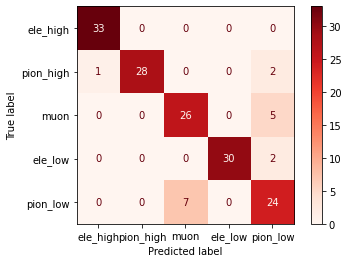

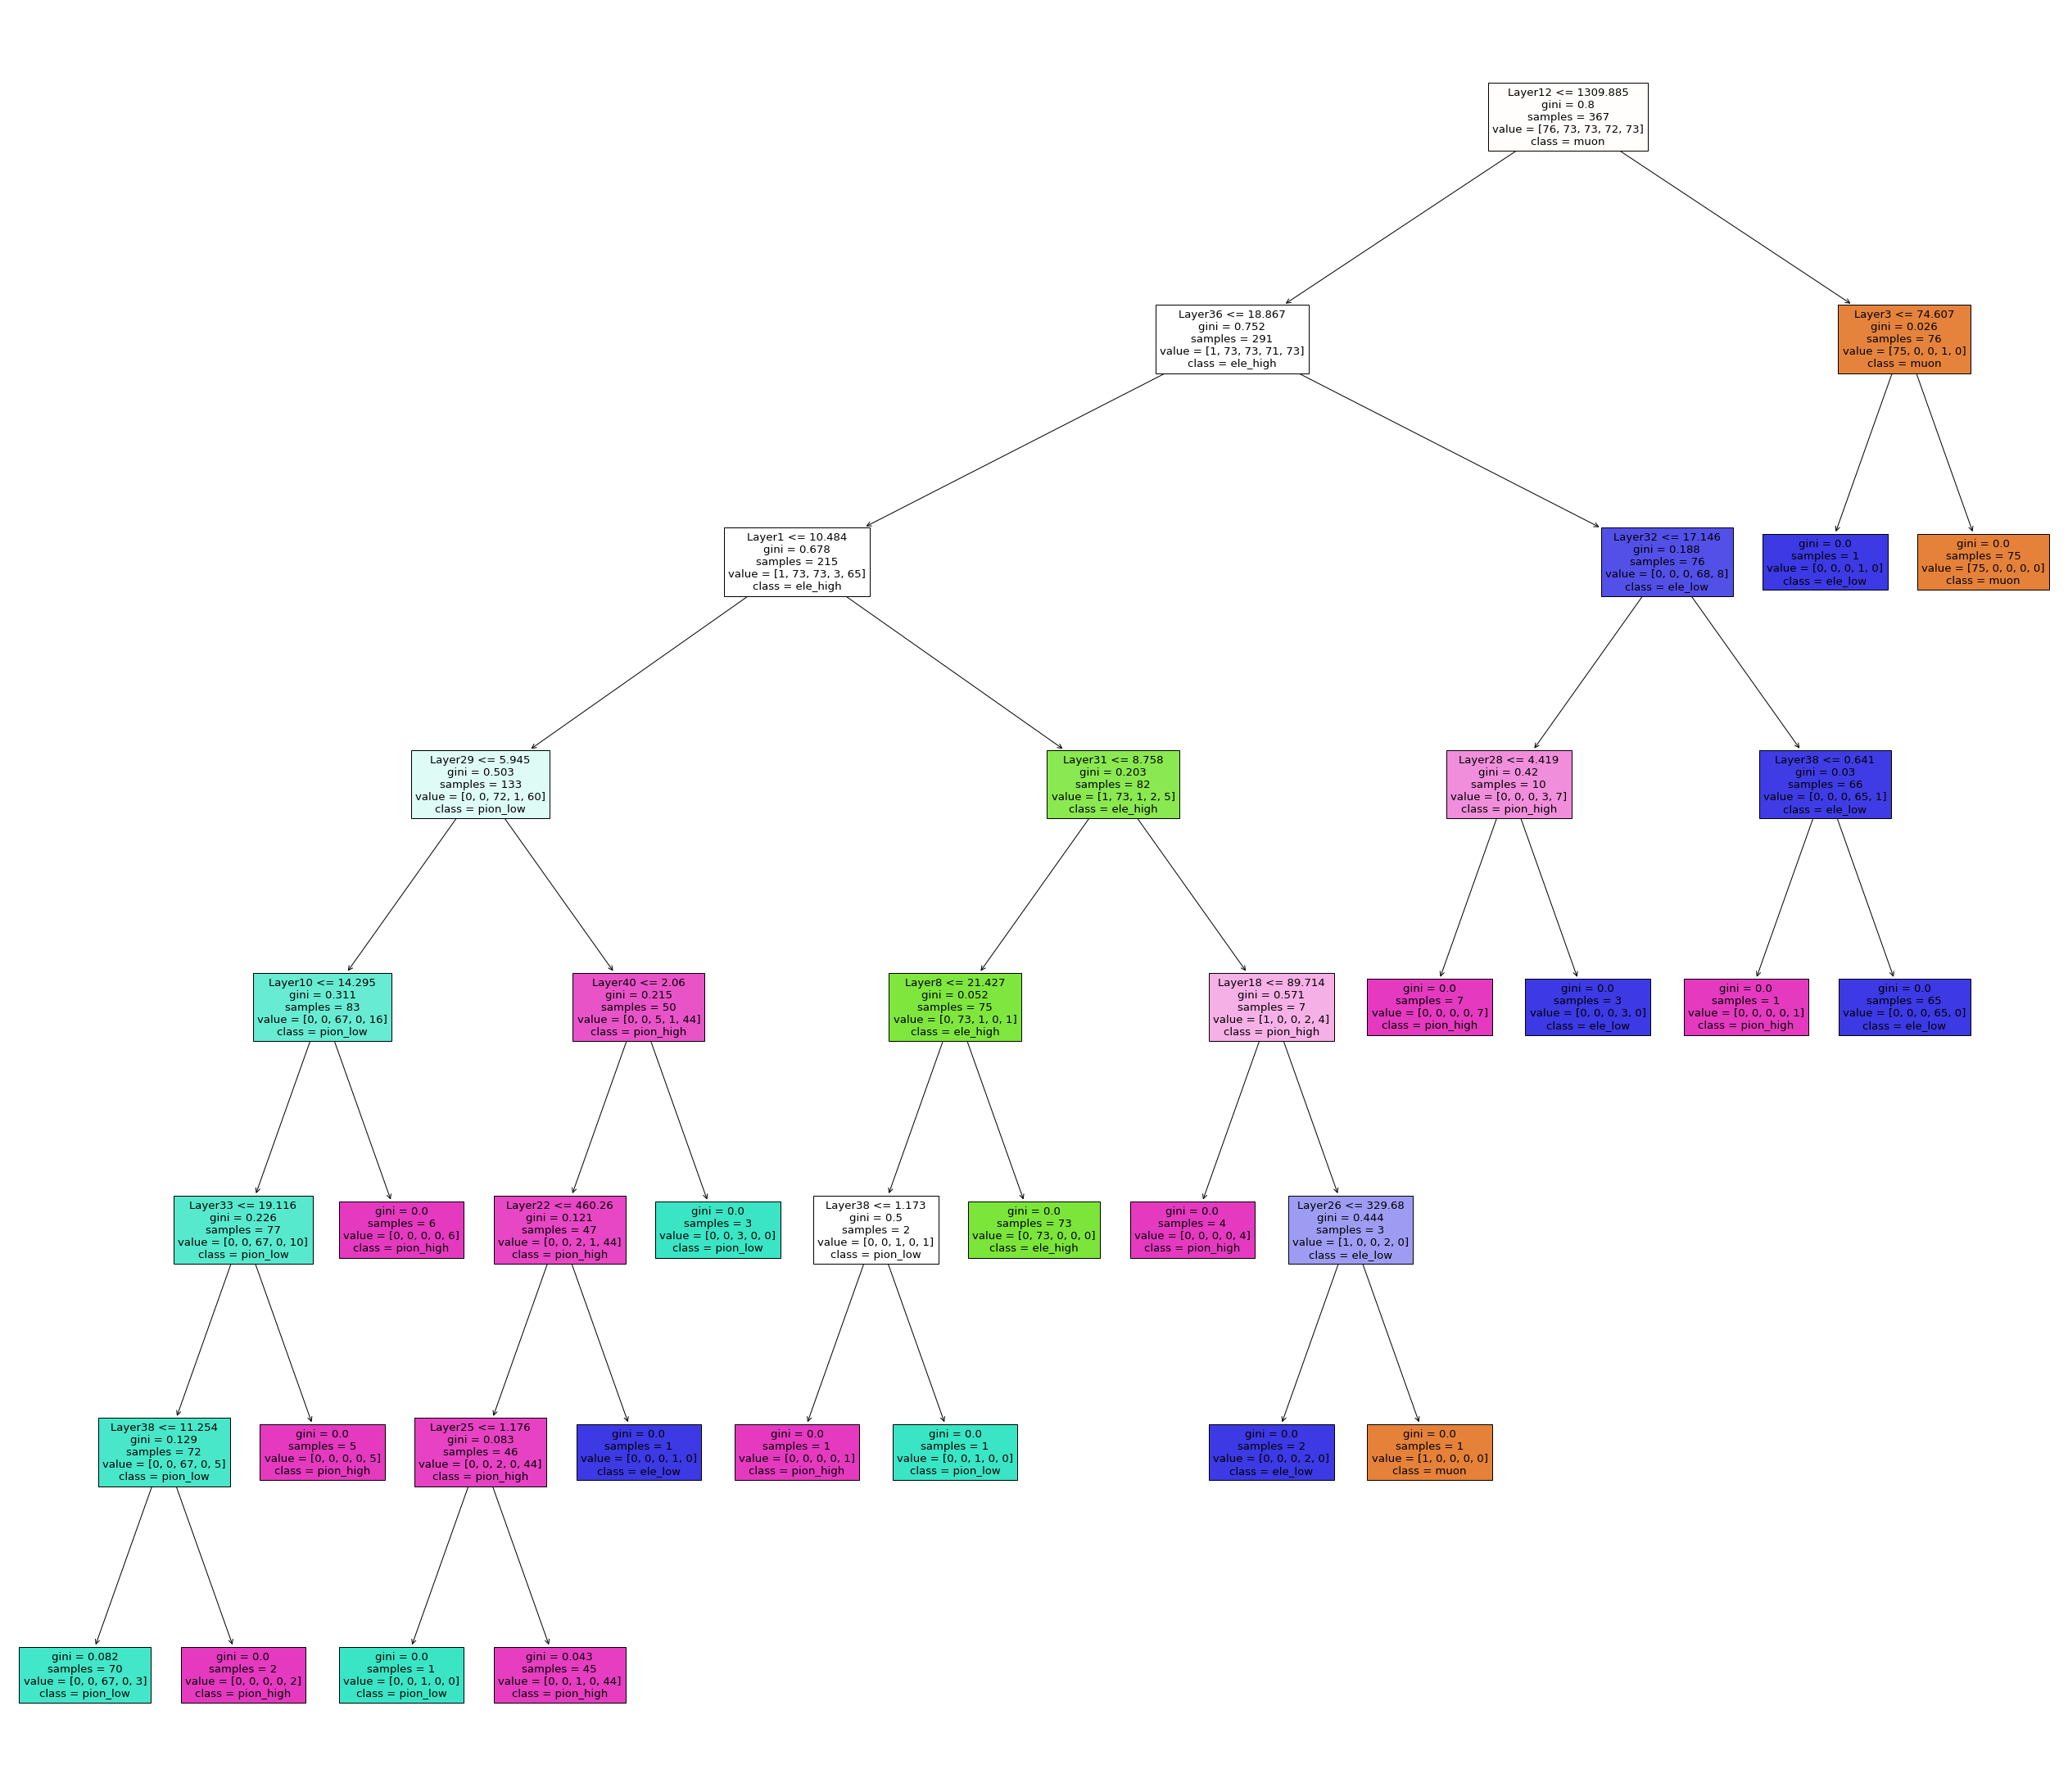

In [130]:
mislabeled_df, feature_importance_df = ModelDecisionTree(df, depth=7)

According to these results, the model's having serious difficulty distinguishing between the muons and low energy pions. We want to check and see samples from mislabeled data.

### Comparing the predictions and the actual results

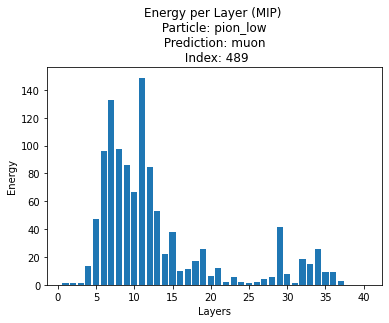

--------------------------------------------------------------------------------------------------------------


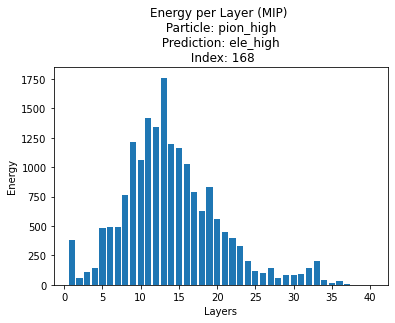

--------------------------------------------------------------------------------------------------------------


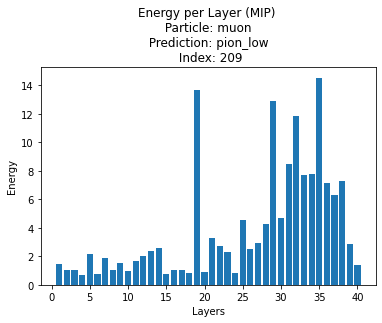

--------------------------------------------------------------------------------------------------------------


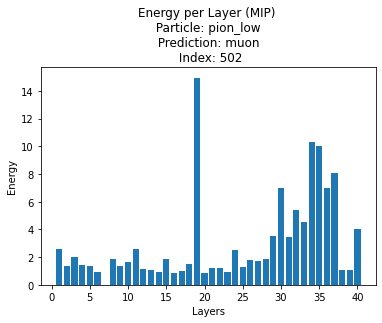

--------------------------------------------------------------------------------------------------------------


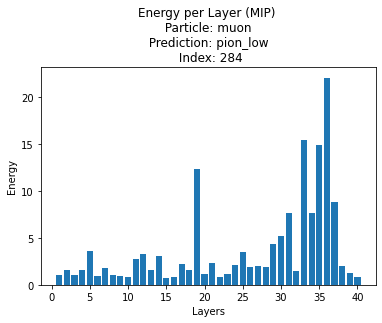

--------------------------------------------------------------------------------------------------------------


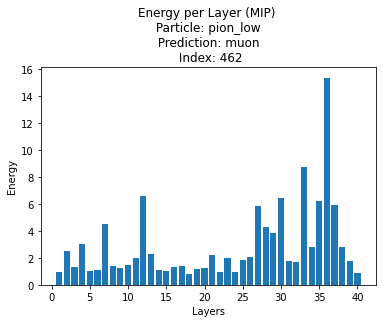

--------------------------------------------------------------------------------------------------------------


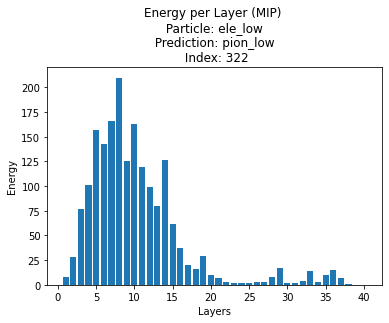

--------------------------------------------------------------------------------------------------------------


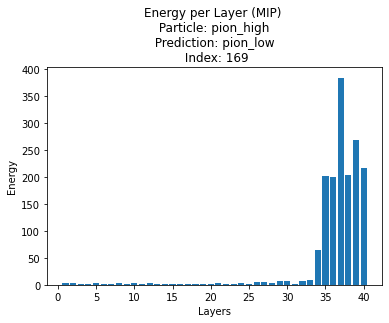

--------------------------------------------------------------------------------------------------------------


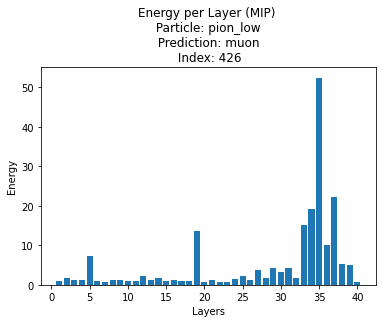

--------------------------------------------------------------------------------------------------------------


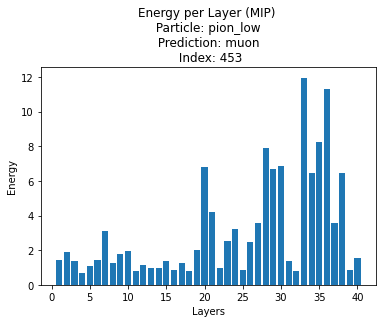

--------------------------------------------------------------------------------------------------------------


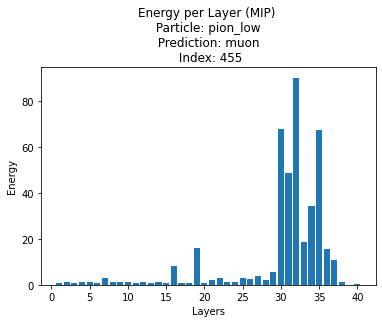

--------------------------------------------------------------------------------------------------------------


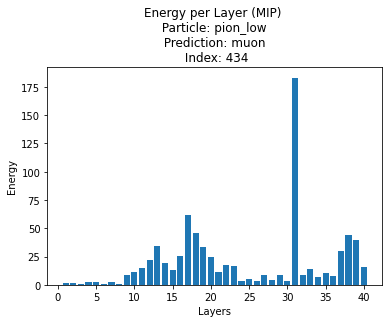

--------------------------------------------------------------------------------------------------------------


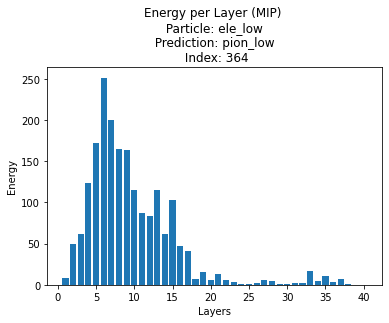

--------------------------------------------------------------------------------------------------------------


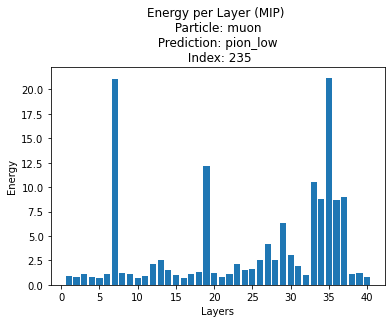

--------------------------------------------------------------------------------------------------------------


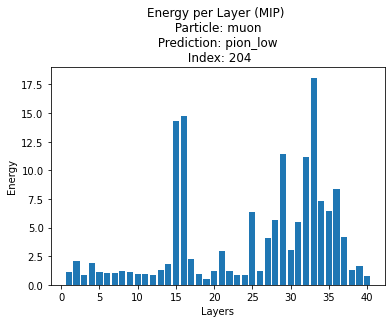

--------------------------------------------------------------------------------------------------------------


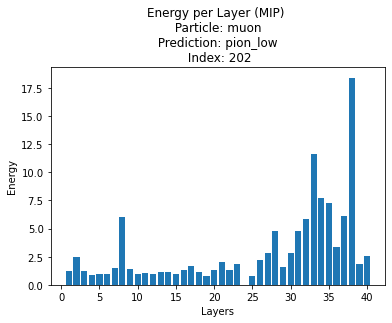

--------------------------------------------------------------------------------------------------------------


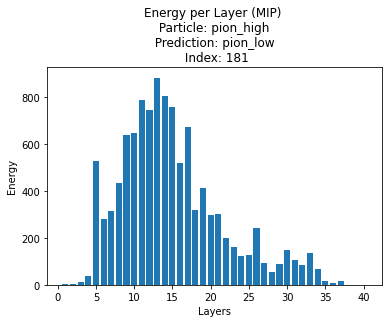

--------------------------------------------------------------------------------------------------------------


In [131]:
MislabeledEventPlotter(mislabeled_df)

### Displaying the importances of the features

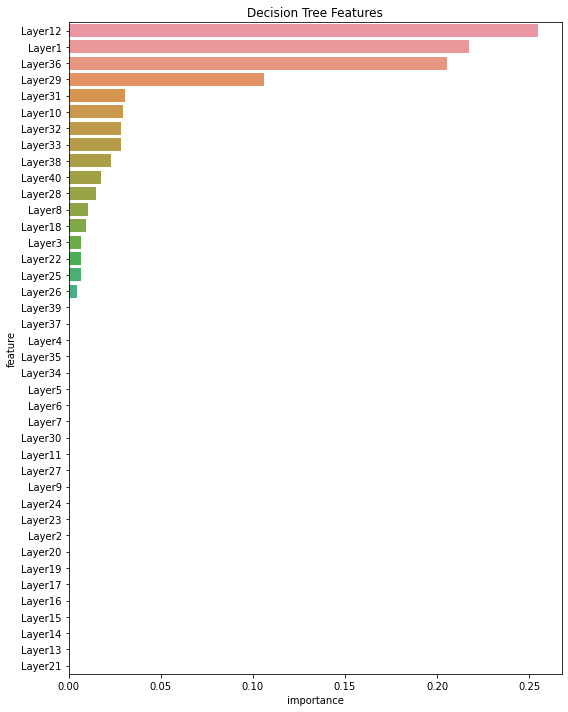

In [132]:
DisplayImportances(feature_importance_df)

### Experiment 2: Training the model with muon data removed

In [14]:
df_without_muon = df[df["Particle"]!="muon"]

In [133]:
GetDatasetDescription(df_without_muon)

Target particles: 
 ['ele_high', 'pion_high', 'ele_low', 'pion_low']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Number of events:  421

ele_high     109
ele_low      105
pion_low     104
pion_high    103
Name: Particle, dtype: int64
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Features: Layer energies


Report :                precision    recall  f1-score   support

    ele_high       1.00      0.97      0.98        33
     ele_low       0.84      1.00      0.91        32
   pion_high       0.86      0.97      0.91        31
    pion_low       0.95      0.68      0.79        31

    accuracy                           0.91       127
   macro avg       0.91      0.90      0.90       127
weighted avg       0.91      0.91      0.90       127

The Confusion Matrix: 


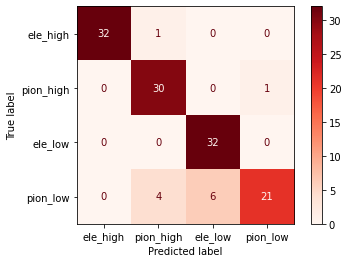

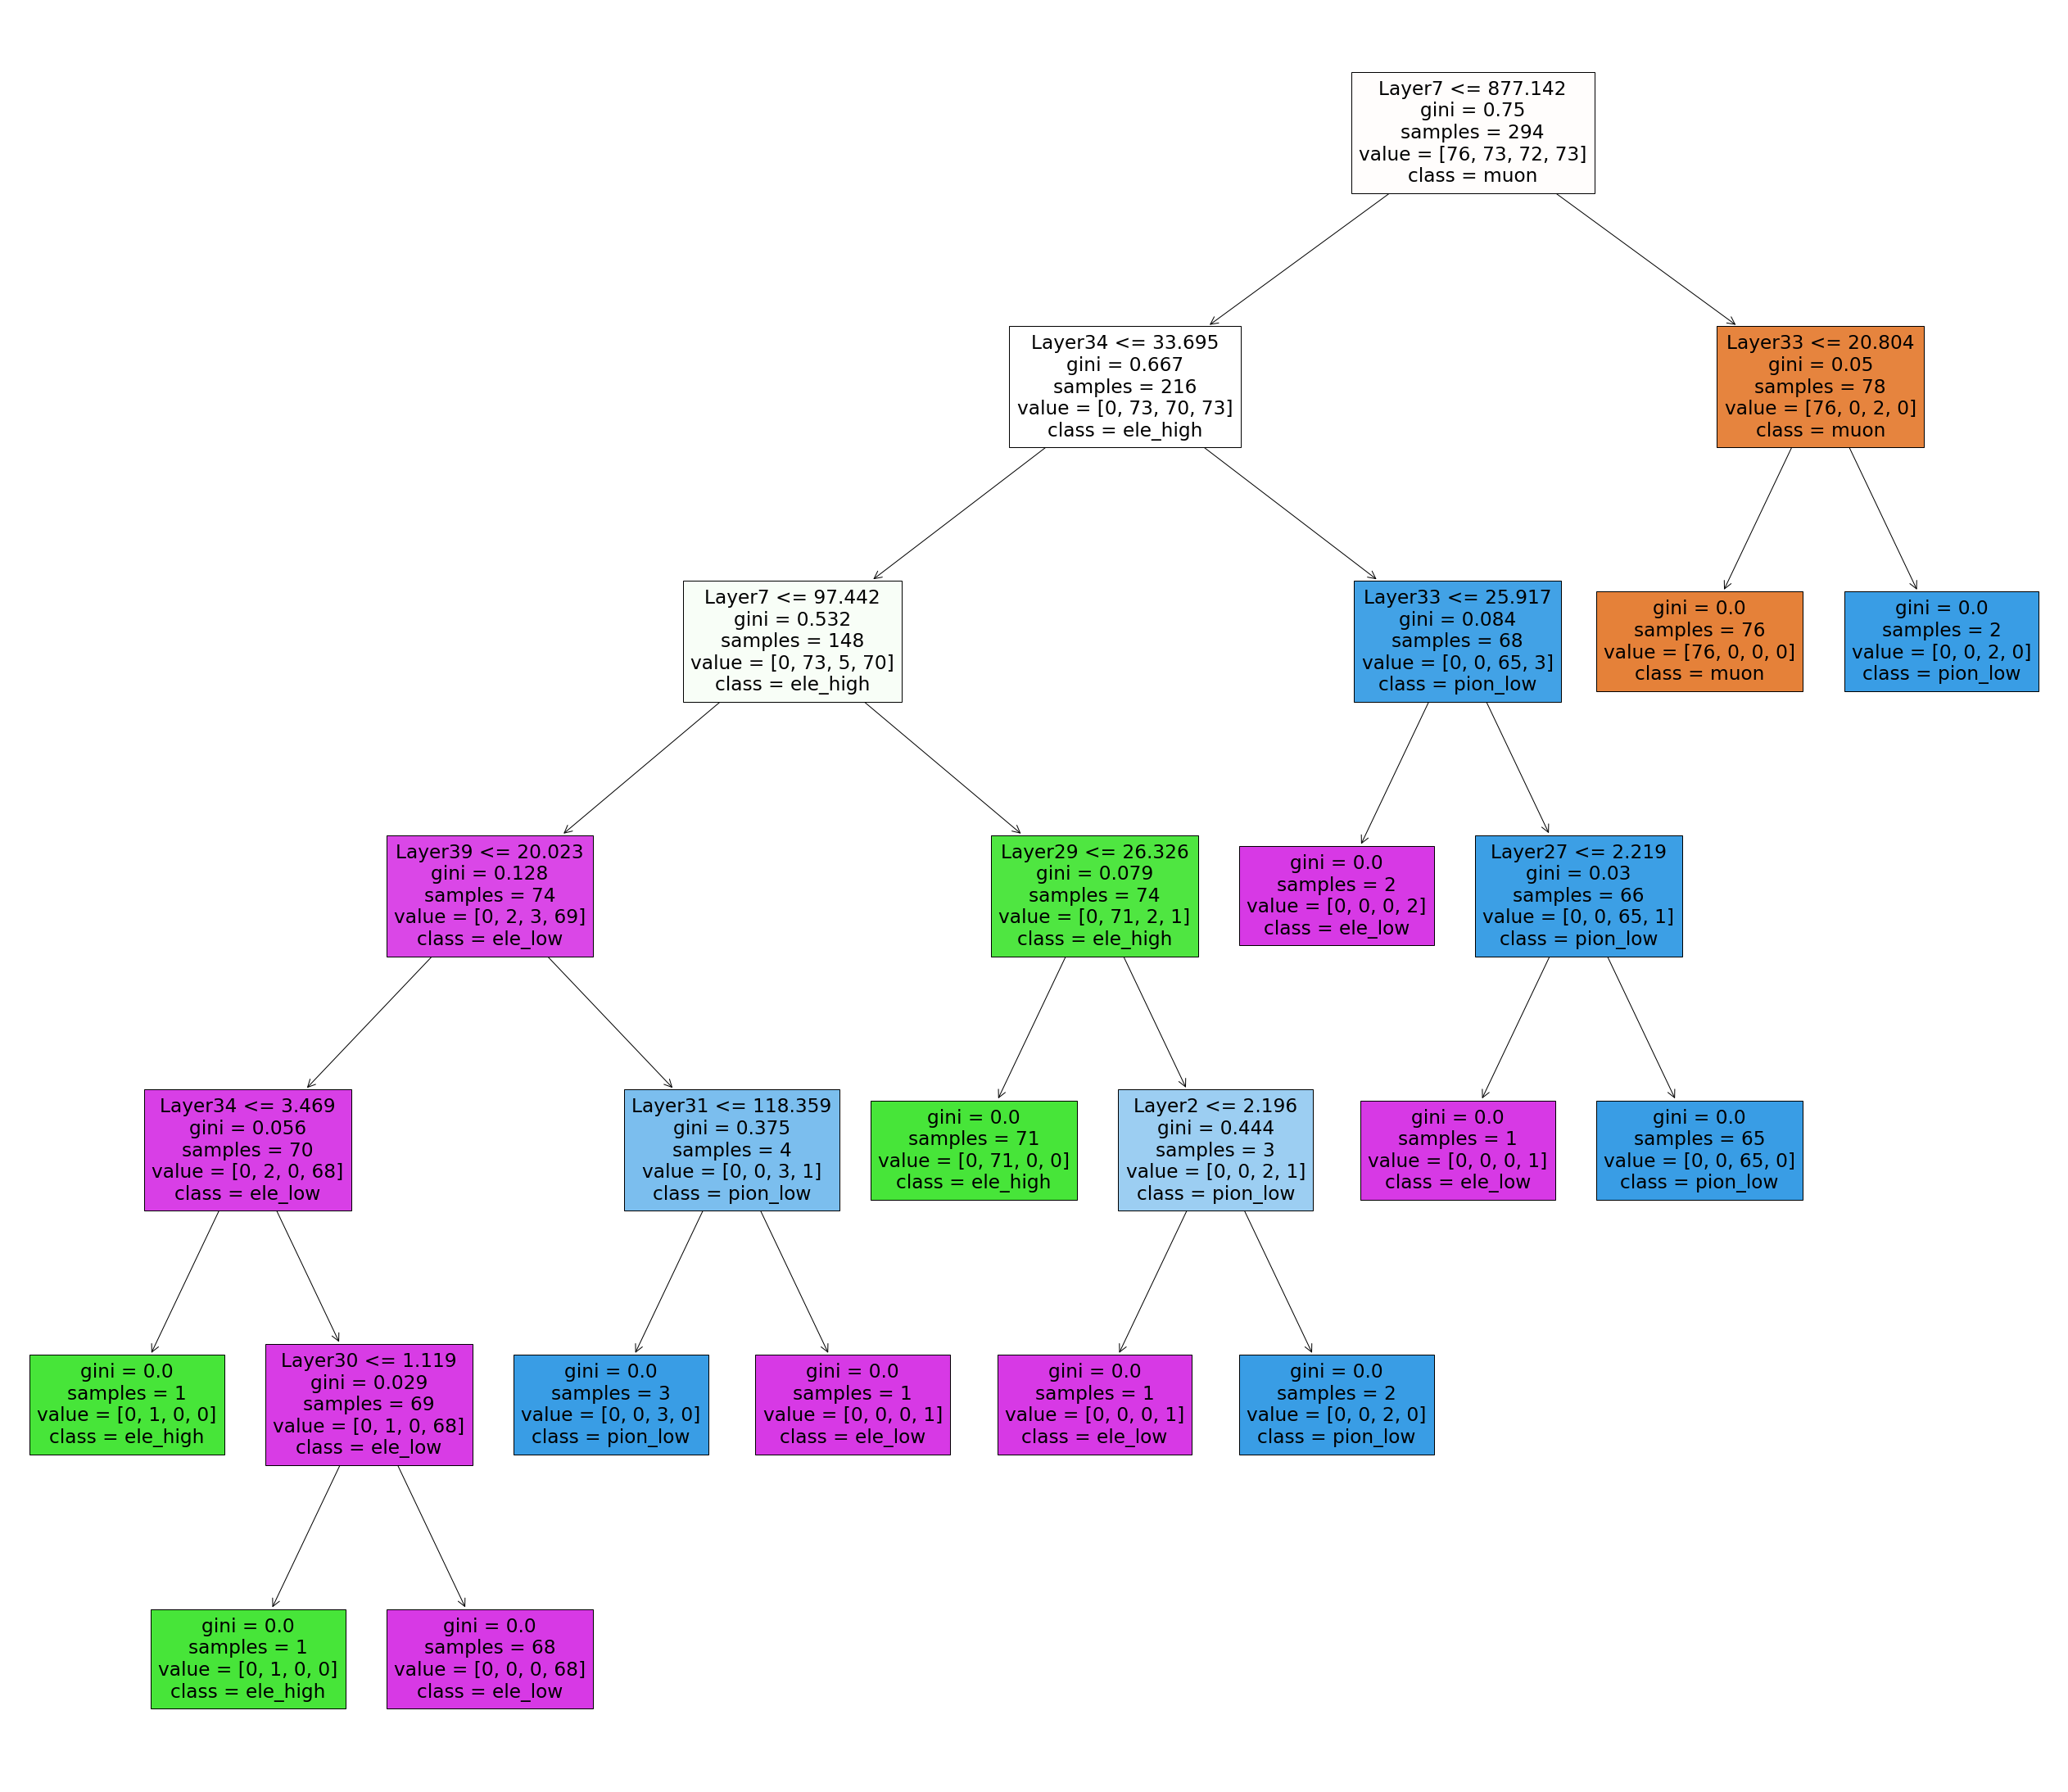

In [134]:
mislabeled_df_2, feature_importance_df_2 = ModelDecisionTree(df_without_muon, 7)

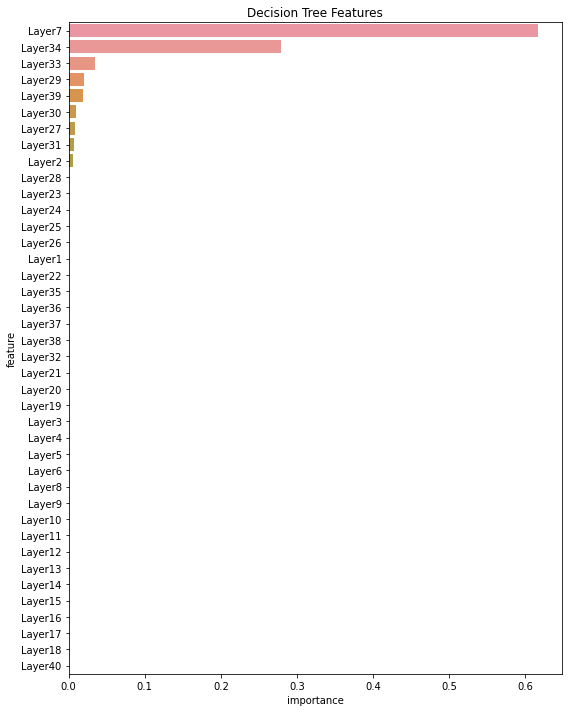

In [135]:
DisplayImportances(feature_importance_df_2)

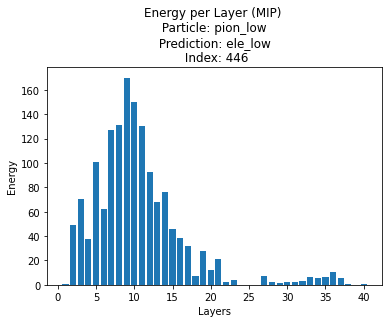

--------------------------------------------------------------------------------------------------------------


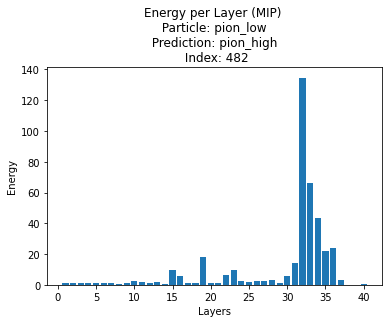

--------------------------------------------------------------------------------------------------------------


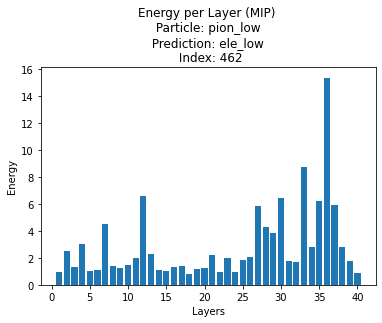

--------------------------------------------------------------------------------------------------------------


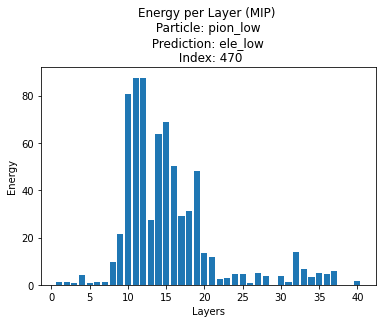

--------------------------------------------------------------------------------------------------------------


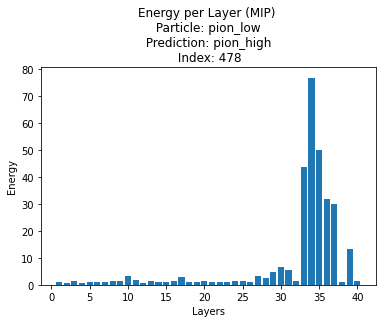

--------------------------------------------------------------------------------------------------------------


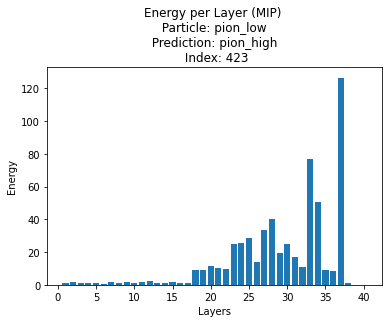

--------------------------------------------------------------------------------------------------------------


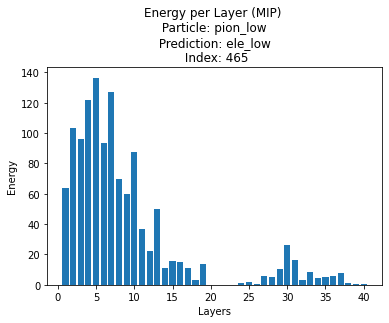

--------------------------------------------------------------------------------------------------------------


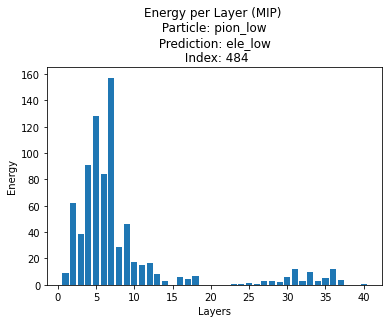

--------------------------------------------------------------------------------------------------------------


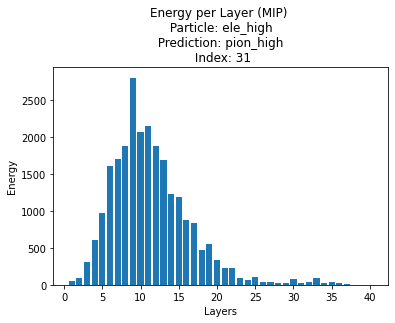

--------------------------------------------------------------------------------------------------------------


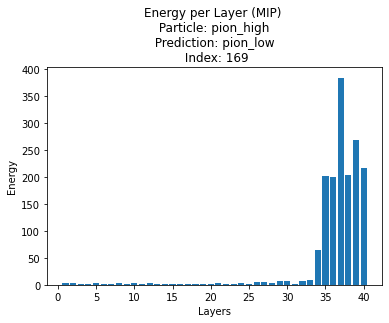

--------------------------------------------------------------------------------------------------------------


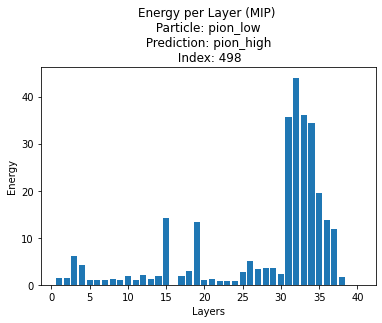

--------------------------------------------------------------------------------------------------------------


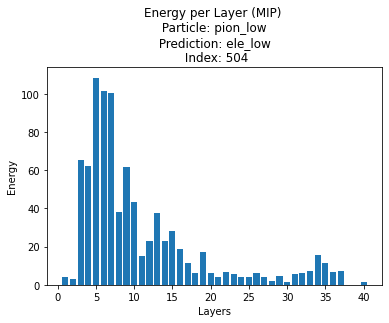

--------------------------------------------------------------------------------------------------------------


In [136]:
MislabeledEventPlotter(mislabeled_df_2)

### Experiment 3: Training the model with pion_low data removed

In [18]:
df_without_pionlow = df[df["Particle"]!="pion_low"]

In [137]:
GetDatasetDescription(df_without_pionlow)

Target particles: 
 ['ele_high', 'pion_high', 'muon', 'ele_low']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Number of events:  421

ele_high     109
ele_low      105
muon         104
pion_high    103
Name: Particle, dtype: int64
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Features: Layer energies


Report :                precision    recall  f1-score   support

    ele_high       0.97      1.00      0.99        33
     ele_low       1.00      1.00      1.00        32
        muon       1.00      1.00      1.00        31
   pion_high       1.00      0.97      0.98        31

    accuracy                           0.99       127
   macro avg       0.99      0.99      0.99       127
weighted avg       0.99      0.99      0.99       127

The Confusion Matrix: 


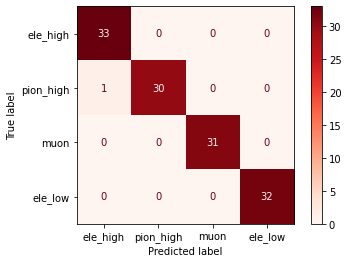

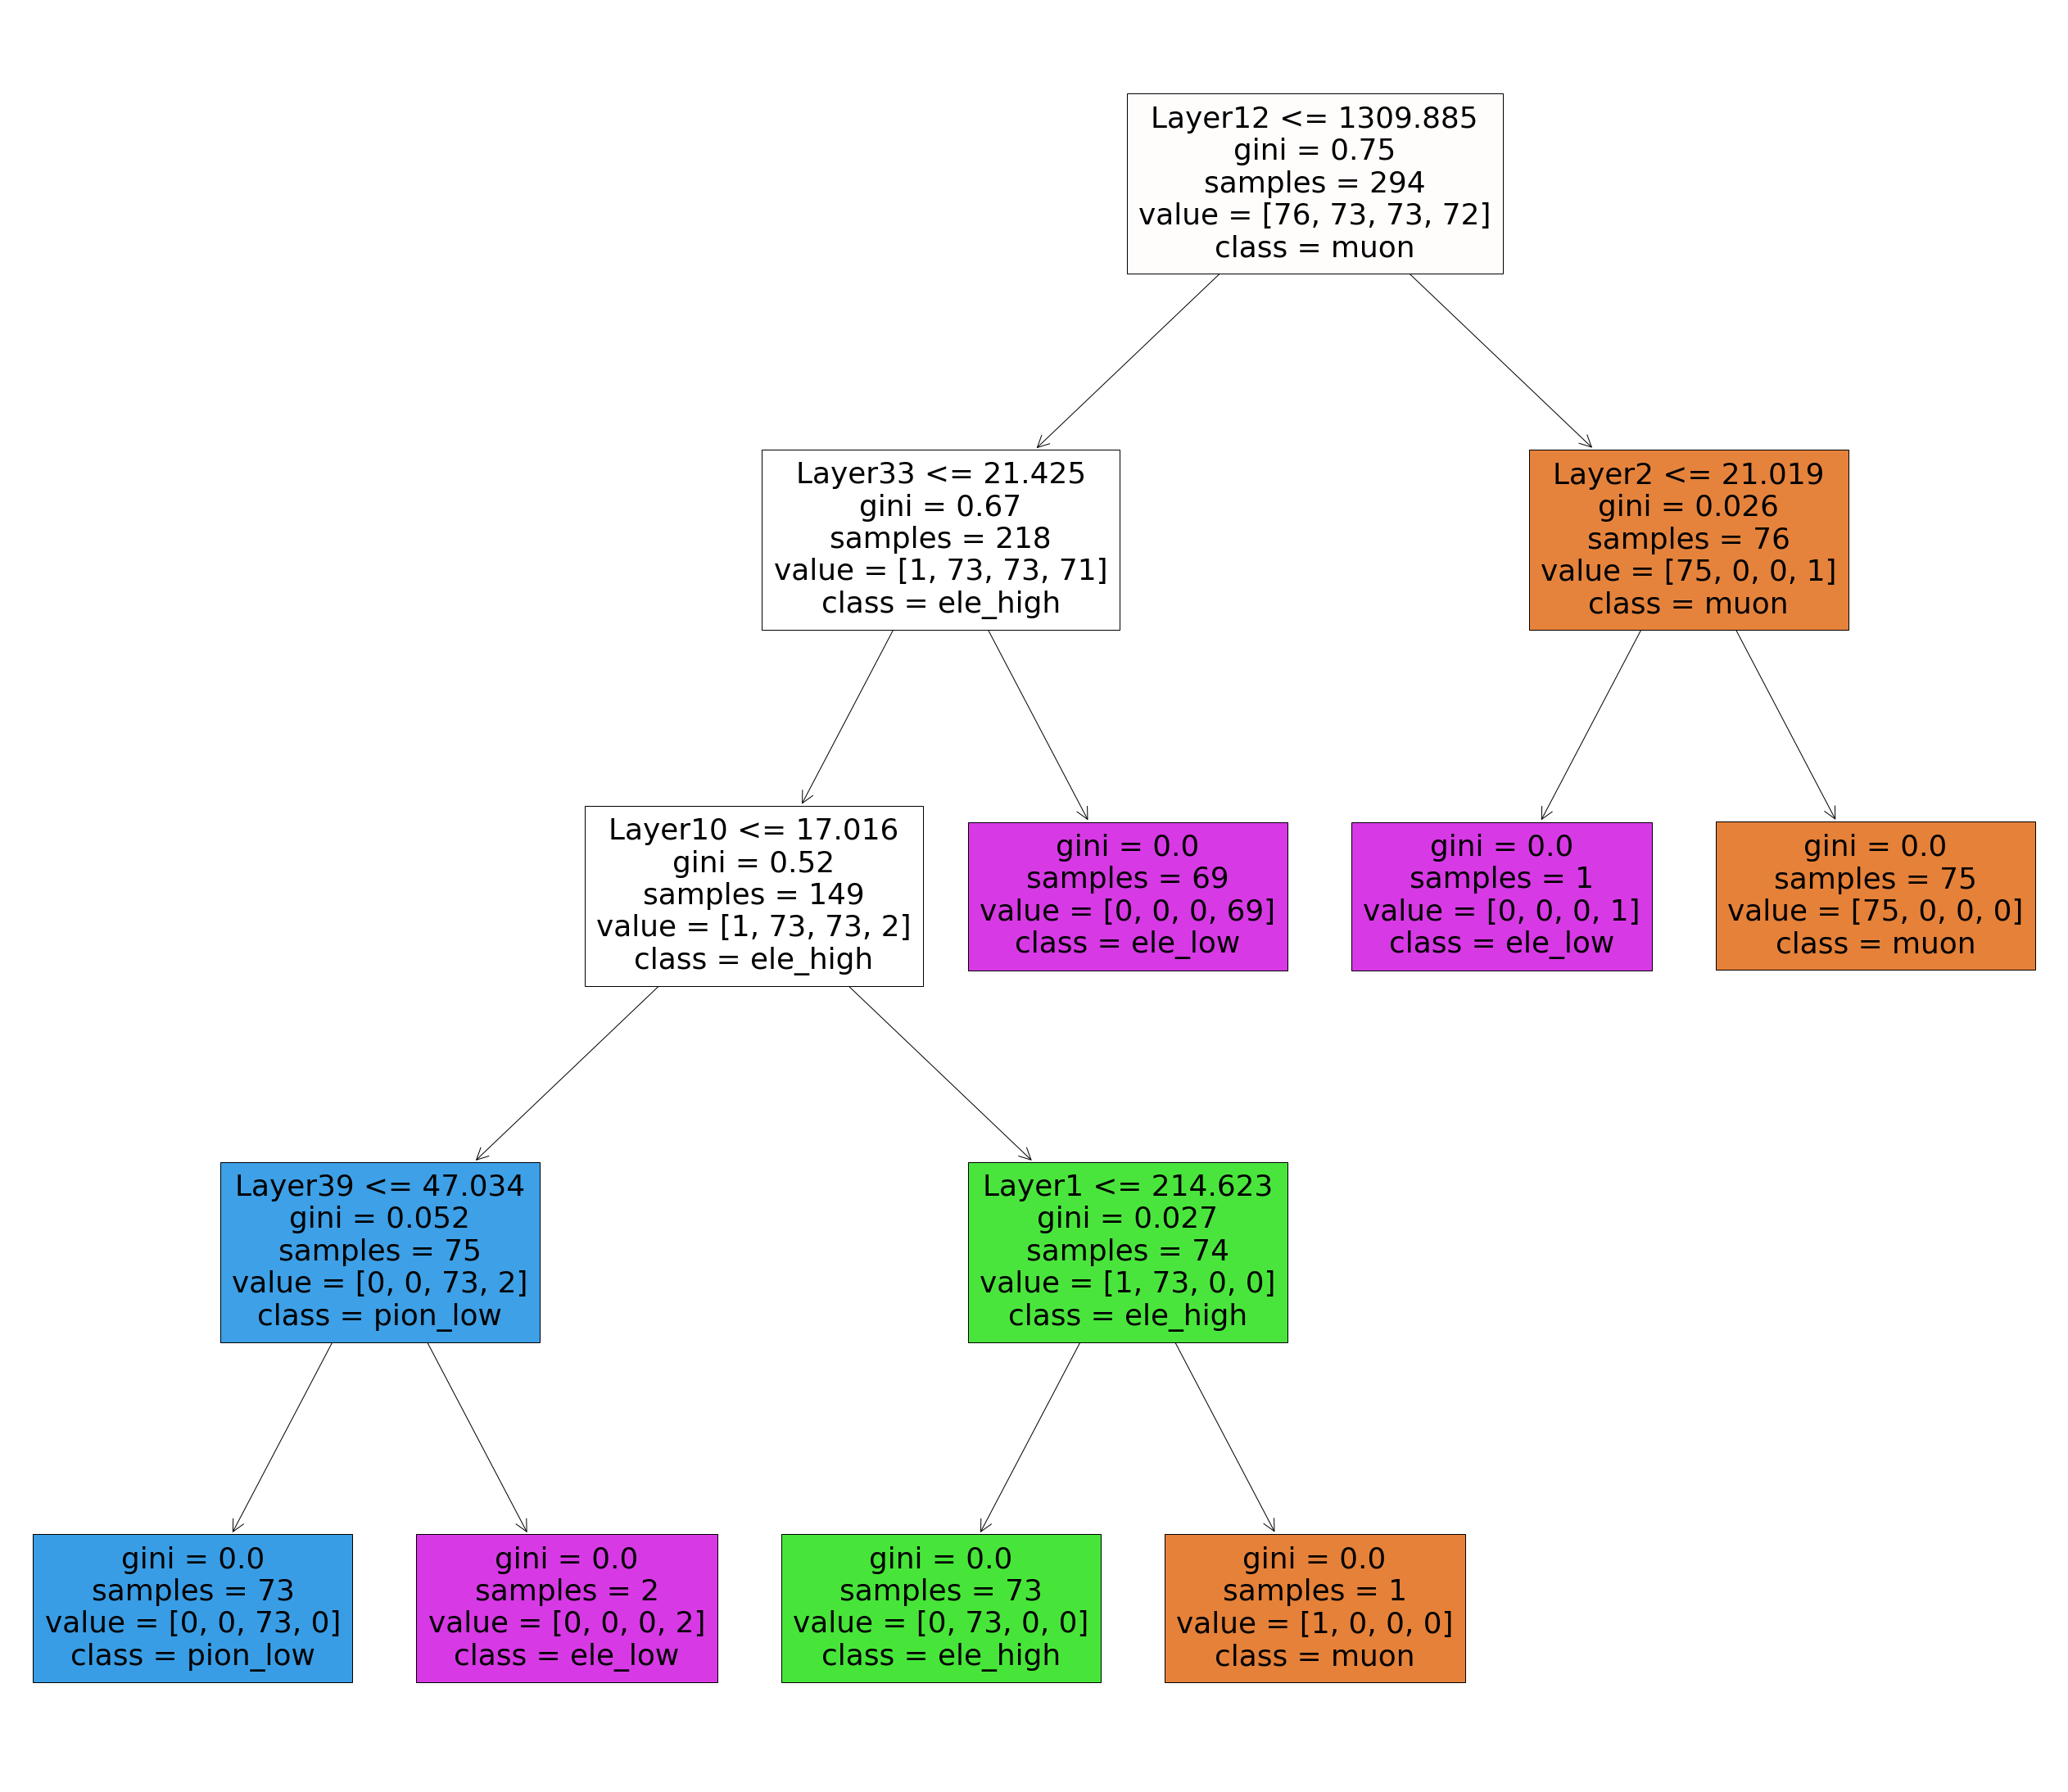

In [139]:
mislabeled_df_3, feature_importance_df_3 = ModelDecisionTree(df_without_pionlow, 7)

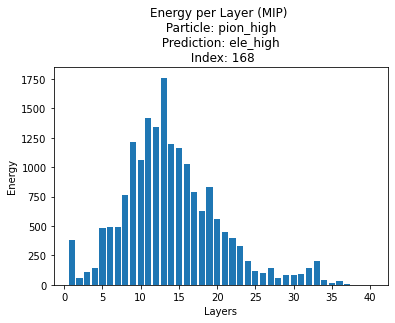

--------------------------------------------------------------------------------------------------------------


In [140]:
MislabeledEventPlotter(mislabeled_df_3)

### Experiment 4: Adding new features

In [141]:
from Functions import AddNewFeatures

In [23]:
df_extra_features = AddNewFeatures(df)

In [143]:
GetDatasetDescription(df_extra_features)

Target particles: 
 ['ele_high', 'pion_high', 'muon', 'ele_low', 'pion_low']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Number of events:  525

ele_high     109
ele_low      105
muon         104
pion_low     104
pion_high    103
Name: Particle, dtype: int64
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Features: Layer energies and ['Energy Ratios', 'Energy At Peak Value 1-28', 'Energy At Peak Value 28_40']


Report :                precision    recall  f1-score   support

    ele_high       1.00      0.97      0.98        33
     ele_low       1.00      1.00      1.00        32
        muon       0.90      0.84      0.87        31
   pion_high       0.97      0.90      0.93        31
    pion_low       0.78      0.90      0.84        31

    accuracy                           0.92       158
   macro avg       0.93      0.92      0.92       158
weighted avg       0.93      0.92      0.93       158

The Confusion Matrix: 


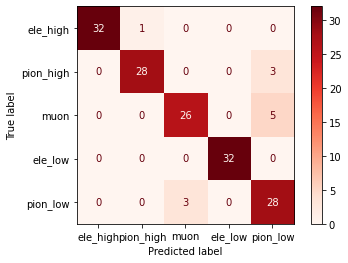

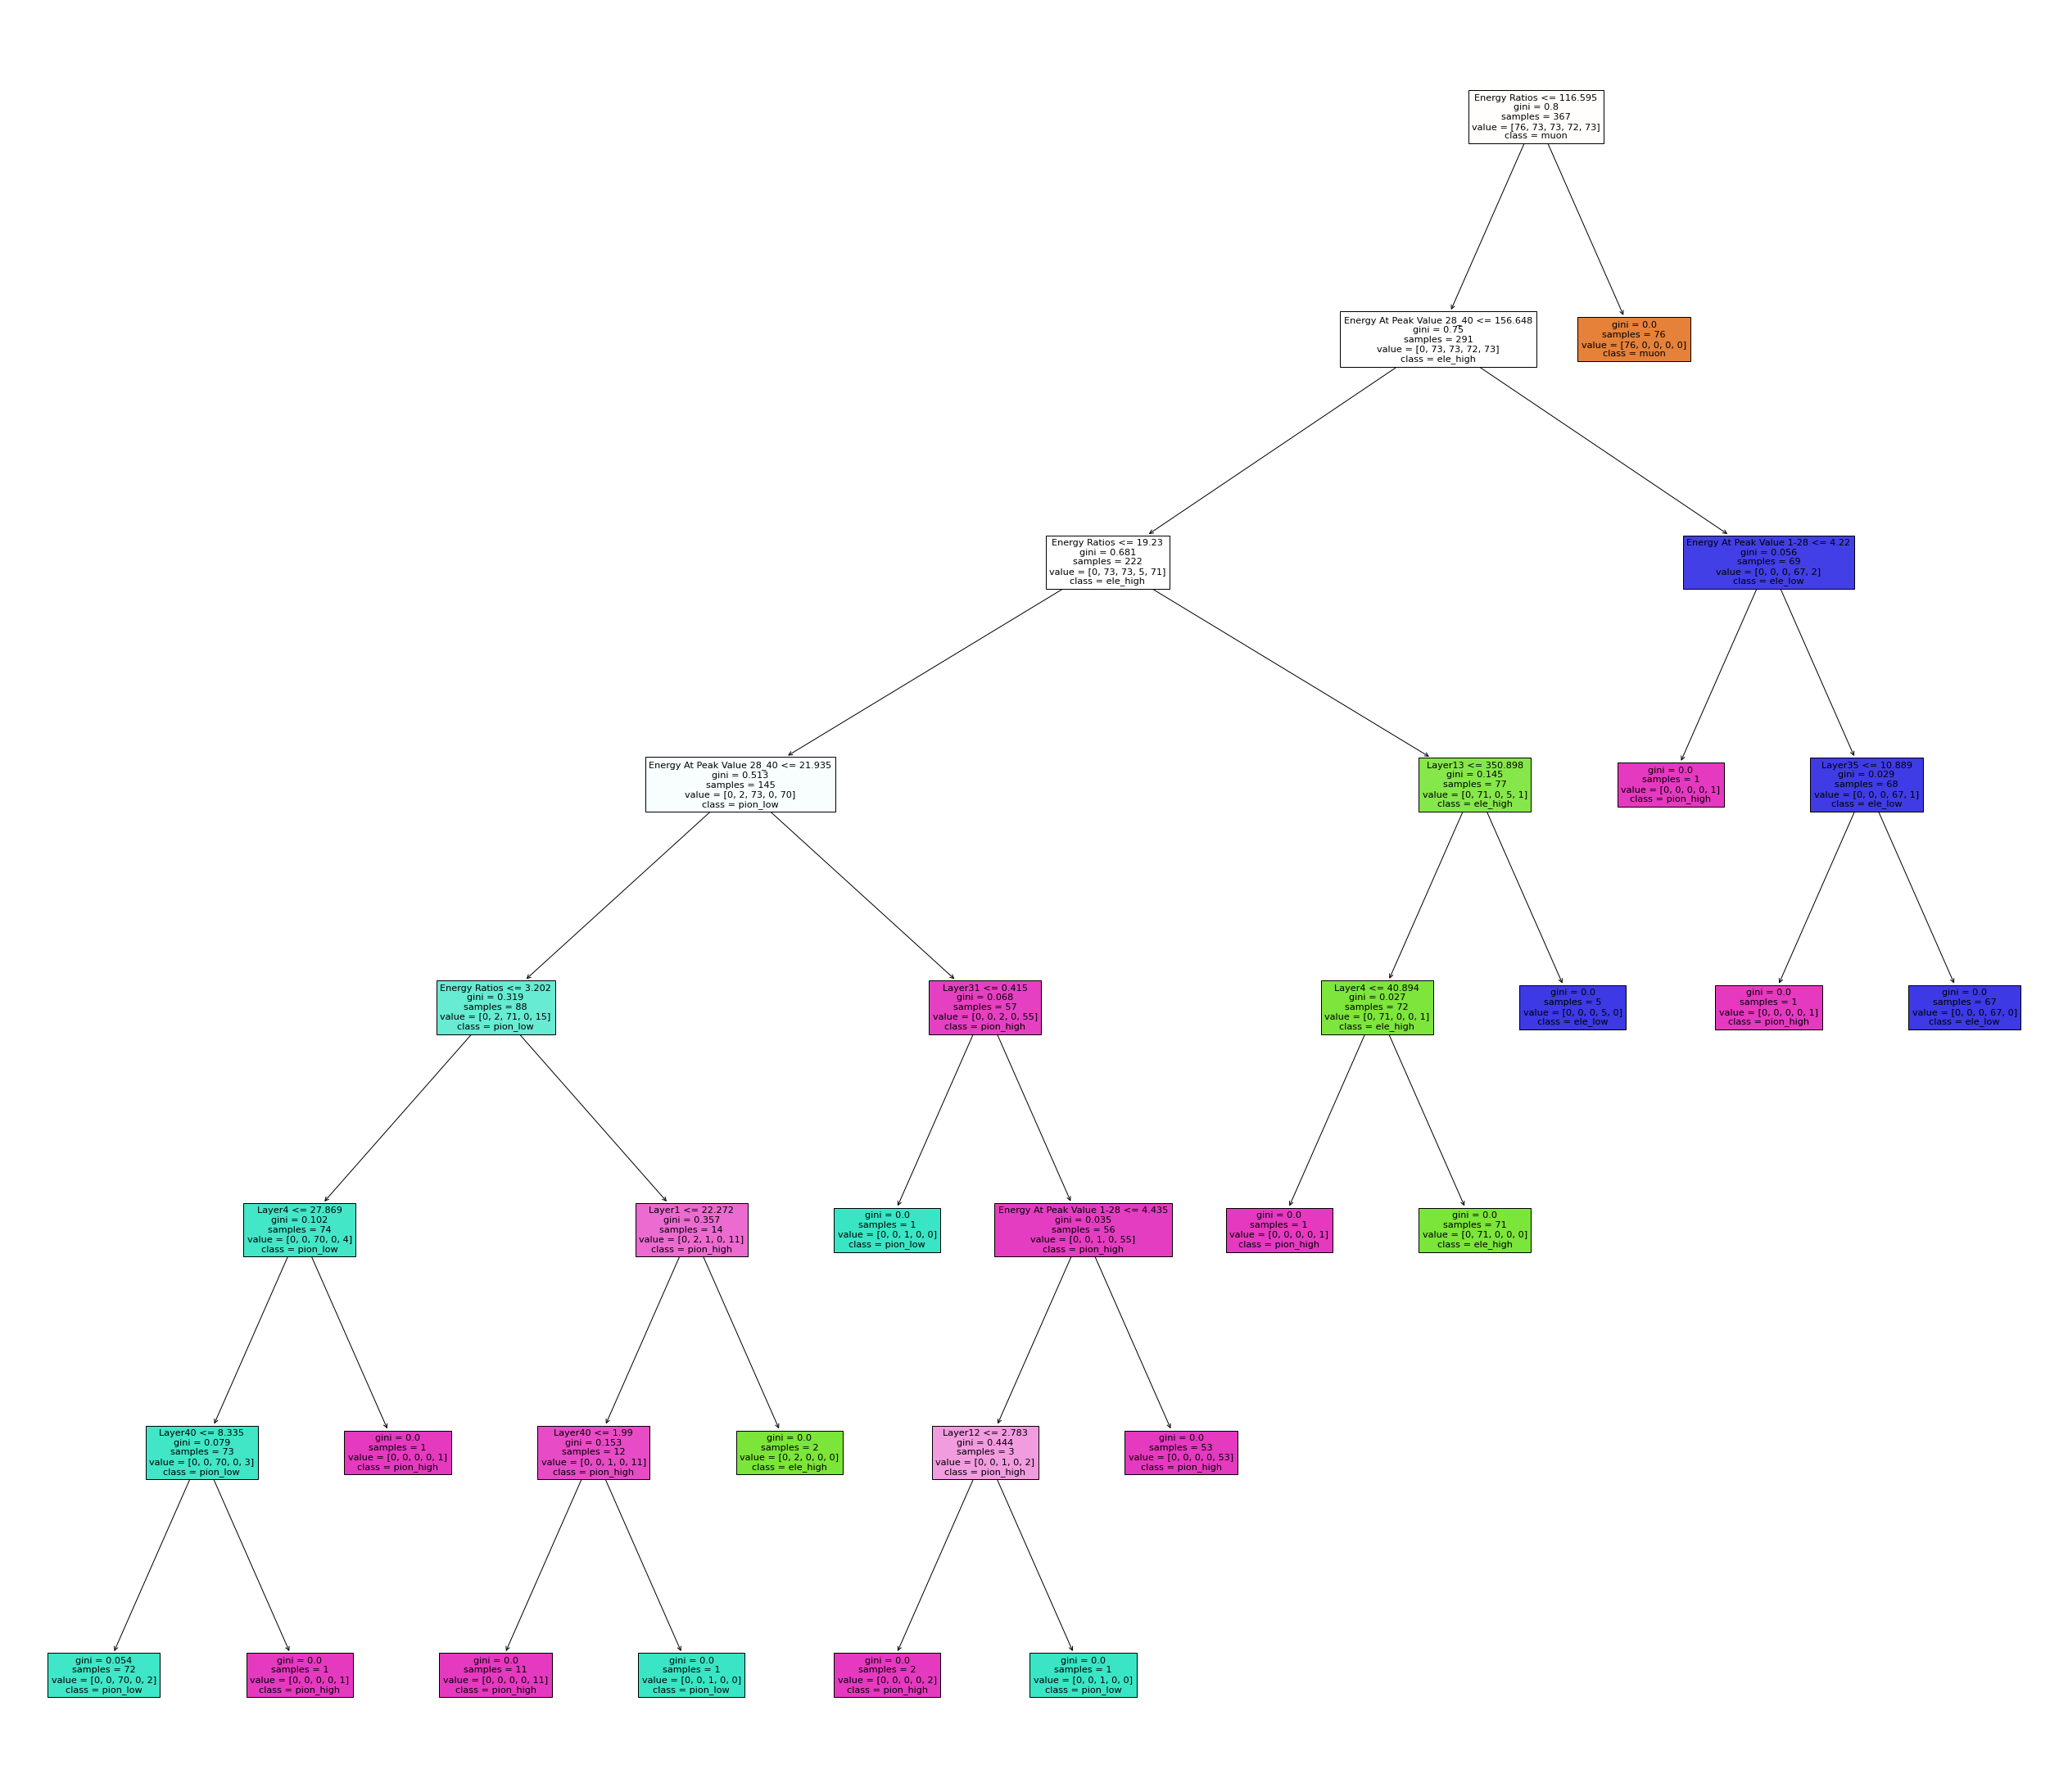

In [145]:
mislabeled_df_4, feature_importance_df_4 = ModelDecisionTree(df_extra_features, 7)

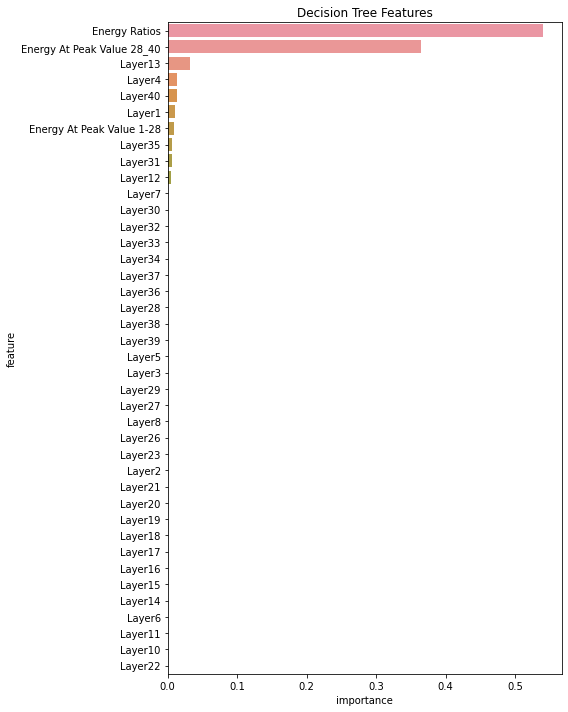

In [146]:
DisplayImportances(feature_importance_df_4)

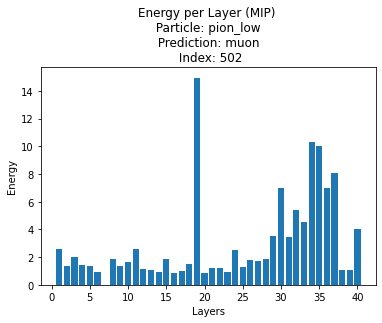

--------------------------------------------------------------------------------------------------------------


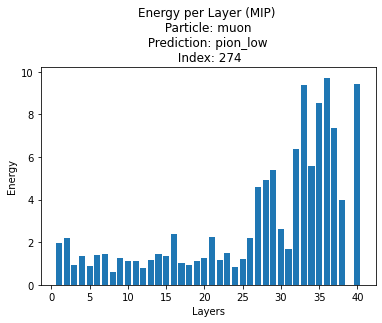

--------------------------------------------------------------------------------------------------------------


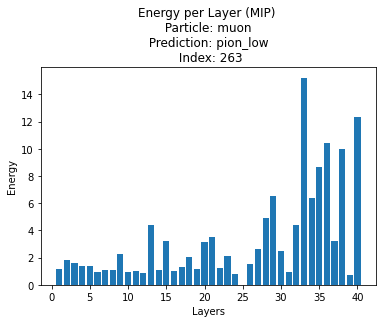

--------------------------------------------------------------------------------------------------------------


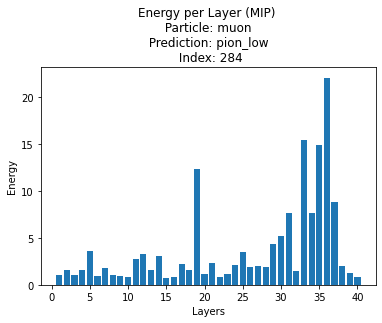

--------------------------------------------------------------------------------------------------------------


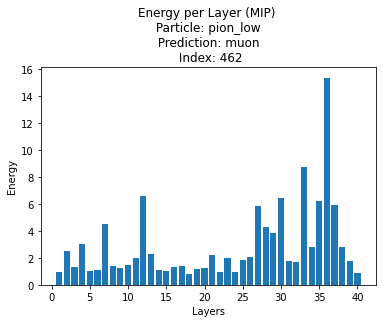

--------------------------------------------------------------------------------------------------------------


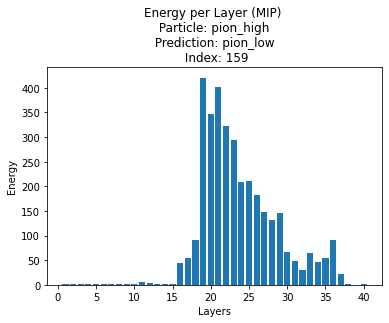

--------------------------------------------------------------------------------------------------------------


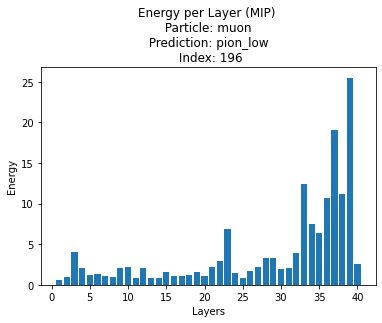

--------------------------------------------------------------------------------------------------------------


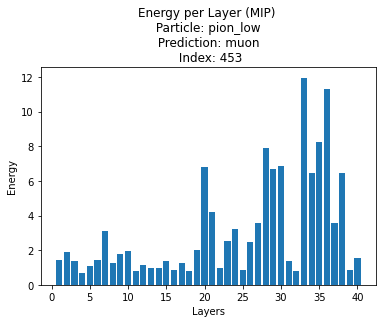

--------------------------------------------------------------------------------------------------------------


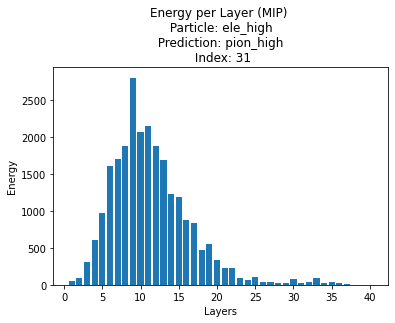

--------------------------------------------------------------------------------------------------------------


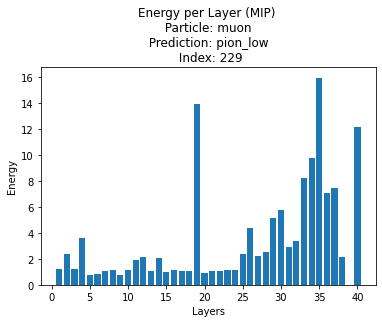

--------------------------------------------------------------------------------------------------------------


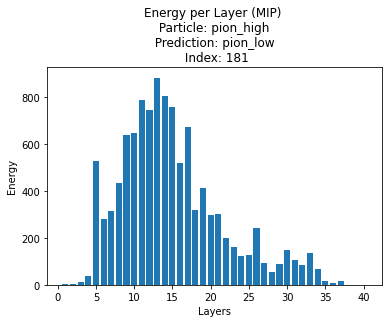

--------------------------------------------------------------------------------------------------------------


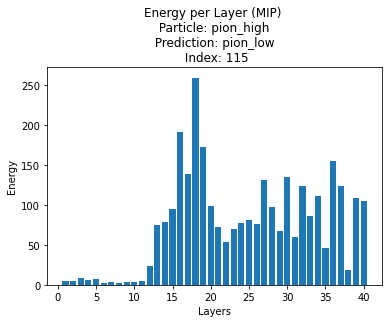

--------------------------------------------------------------------------------------------------------------


In [147]:
MislabeledEventPlotter(mislabeled_df_4)

### Hyperparameter Optimization Using Cross Validation to find the max tree depth

In [148]:
from sklearn.model_selection import cross_val_score

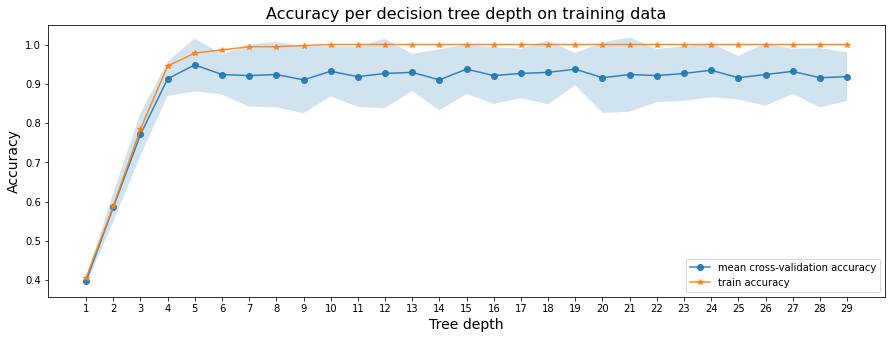

In [150]:
X = df_extra_features.drop("Particle", inplace=False, axis=1)
Y = df_extra_features["Particle"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size =0.3,
                                                    random_state = 100,
                                                    shuffle = True, stratify = Y)

# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# fitting trees of depth 1 to 30
sm_tree_depths = range(1,30)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation(X_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')
 


In [151]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))


The depth-5 tree achieves the best mean cross-validation accuracy 94.82044 +/- 3.36673% on training dataset


In [152]:
#Setting max depth to 5 and getting the results

Report :                precision    recall  f1-score   support

    ele_high       1.00      0.97      0.98        33
     ele_low       1.00      0.97      0.98        32
        muon       0.91      0.94      0.92        31
   pion_high       0.97      0.90      0.93        31
    pion_low       0.82      0.90      0.86        31

    accuracy                           0.94       158
   macro avg       0.94      0.94      0.94       158
weighted avg       0.94      0.94      0.94       158

The Confusion Matrix: 


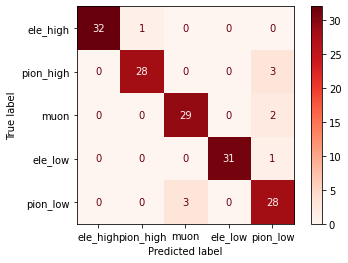

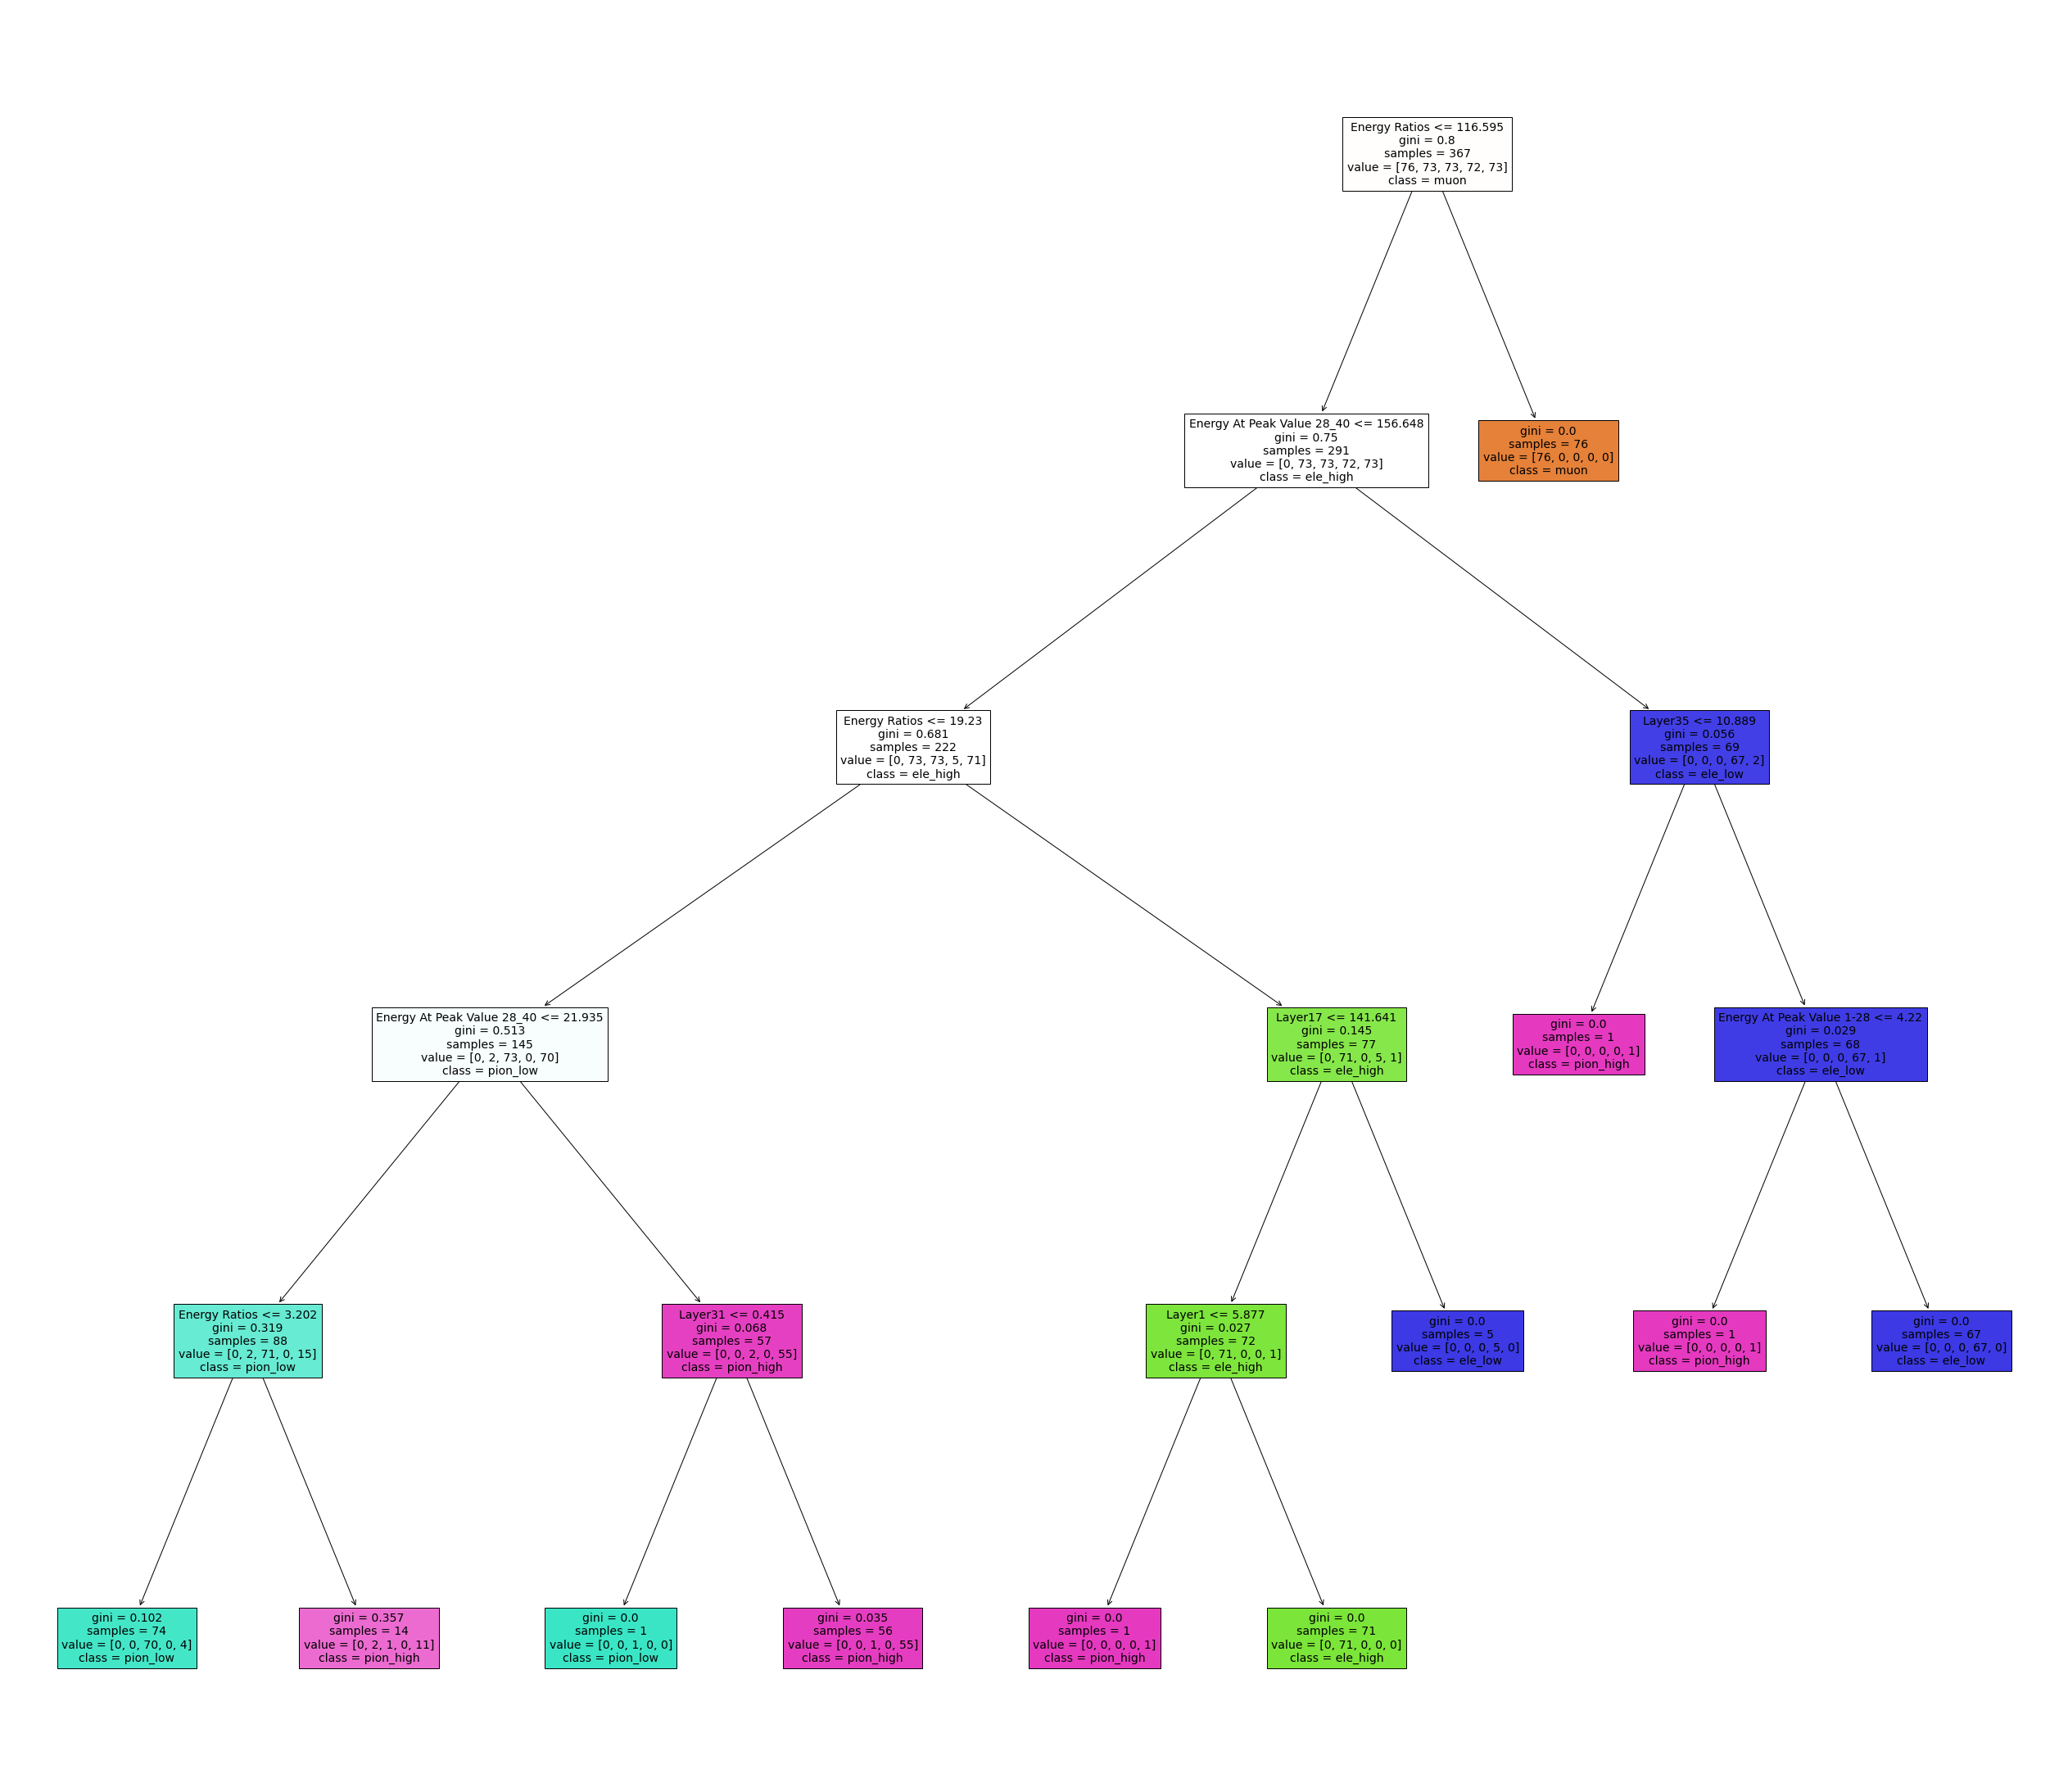

In [153]:
mislabeled_df_5, feature_importance_df_5 = ModelDecisionTree(df_extra_features, depth=5)

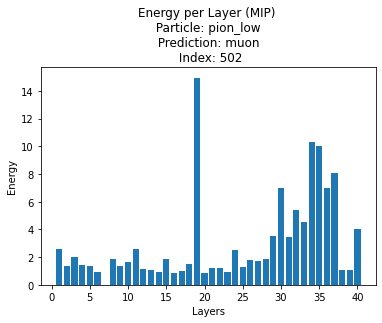

--------------------------------------------------------------------------------------------------------------


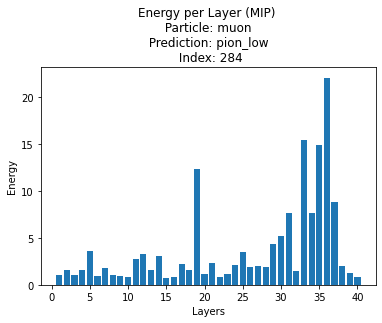

--------------------------------------------------------------------------------------------------------------


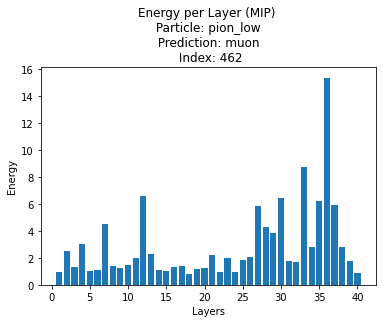

--------------------------------------------------------------------------------------------------------------


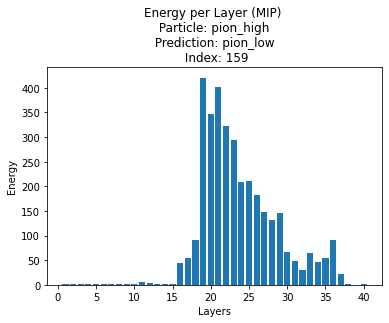

--------------------------------------------------------------------------------------------------------------


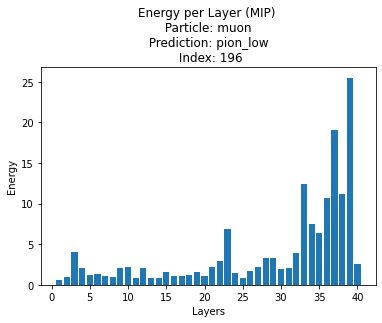

--------------------------------------------------------------------------------------------------------------


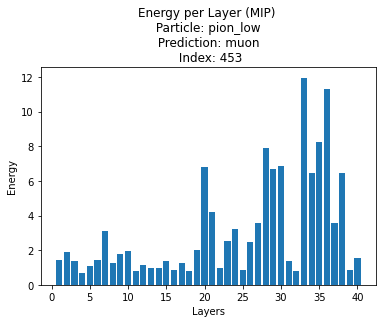

--------------------------------------------------------------------------------------------------------------


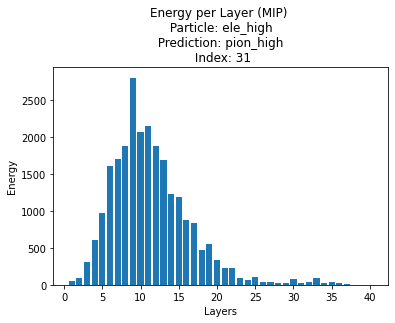

--------------------------------------------------------------------------------------------------------------


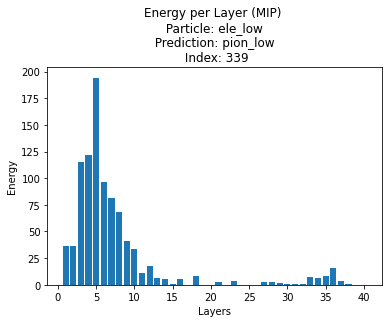

--------------------------------------------------------------------------------------------------------------


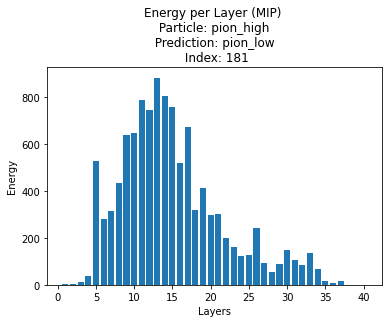

--------------------------------------------------------------------------------------------------------------


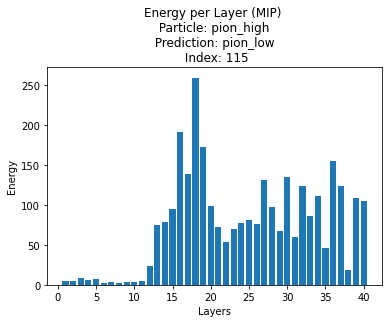

--------------------------------------------------------------------------------------------------------------


In [154]:
MislabeledEventPlotter(mislabeled_df_5)

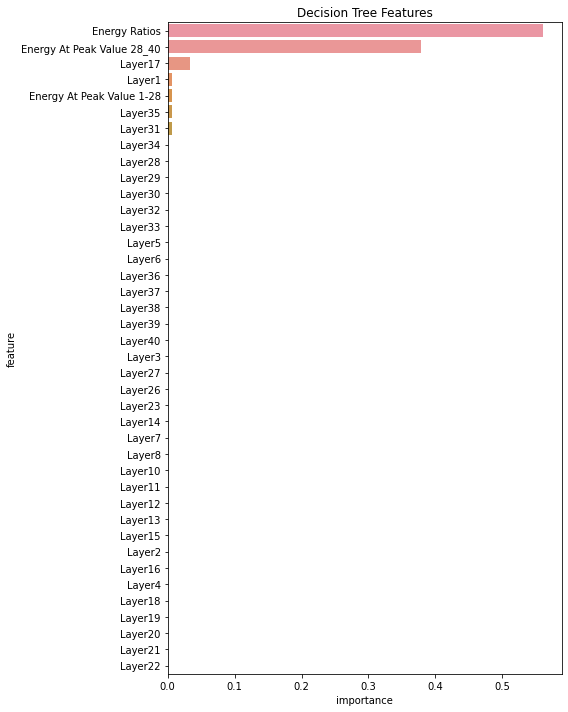

In [155]:
DisplayImportances(feature_importance_df_5)